In [0]:
#https://www.tensorflow.org/tutorials/keras/regression
#Basic regression: Predict fuel efficiency

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np

TensorFlow 2.x selected.


In [3]:
# Use seaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs


In [0]:
import pandas as pd
import seaborn as sns
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 4us/step


'/root/.keras/datasets/auto-mpg.data'

In [6]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] #Esto es para pandas
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [0]:
#Clean data, get all the columns worth n/a and drop them
dataset.isna().sum()
dataset = dataset.dropna()



In [8]:
#The "Origin" column is really categorical, not numeric. So convert that to a one-hot:
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [0]:
#get train and test set
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)


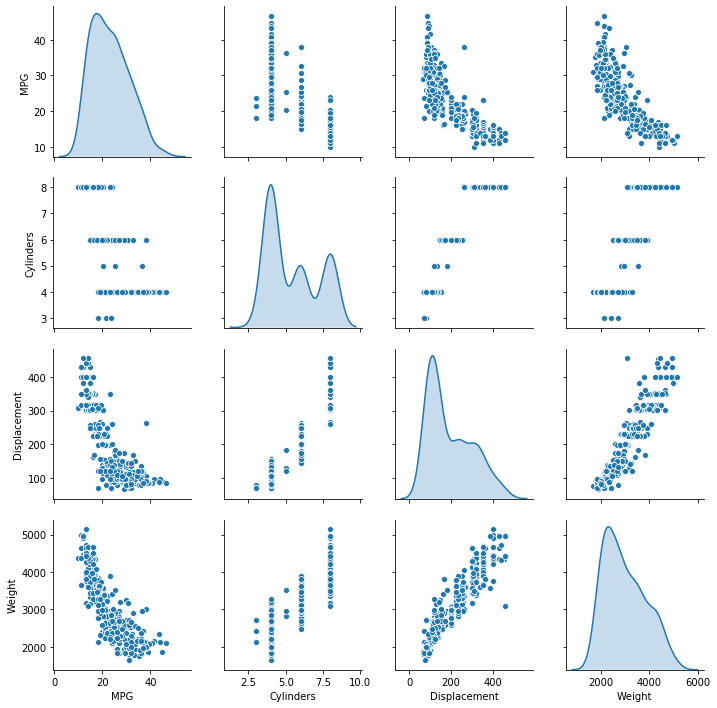

In [10]:
#Inspect data
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")


In [12]:
#Overall statics
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [0]:
#Split features from labels, we want the mpg to be what we predict
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')


In [0]:
#@title normalize the data

In [0]:
#simple value - mean over std, goes from negatice to positive
"""
Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model,
along with the one-hot encoding that we did earlier. That includes the test set as well as live data when the model is used in production.
"""
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


In [19]:
normed_test_data

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
9,1.483887,1.865988,2.234620,1.018782,-2.530891,-1.604642,-0.465148,-0.495225,0.774676
25,1.483887,1.578444,2.890853,1.925289,-0.559020,-1.604642,-0.465148,-0.495225,0.774676
28,1.483887,1.041693,2.313368,2.063931,1.054328,-1.604642,-0.465148,-0.495225,0.774676
31,-0.869348,-0.789008,-0.259066,-0.903250,-0.559020,-1.332580,-0.465148,2.012852,-1.286751
33,0.307270,0.351586,-0.127819,-0.422150,-0.917542,-1.332580,-0.465148,-0.495225,0.774676
...,...,...,...,...,...,...,...,...,...
369,-0.869348,-0.798593,-0.442811,-0.705359,0.875068,1.660094,-0.465148,-0.495225,0.774676
375,-0.869348,-0.865687,-0.810302,-1.197124,-0.092942,1.660094,2.143005,-0.495225,-1.286751
382,-0.869348,-0.836932,-0.915299,-0.883106,0.480693,1.660094,-0.465148,2.012852,-1.286751
384,-0.869348,-0.999874,-0.994047,-1.214899,0.050467,1.660094,-0.465148,2.012852,-1.286751


In [0]:
#@title build the model 

In [27]:
train_dataset.shape

(314, 9)

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]), #input shape is [9]
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [29]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [32]:
#Now try out the model. Take a batch of 10 examples from the training data and call model.predict on it.
example_batch = normed_train_data[:10]
print(example_batch.shape)
example_result = model.predict(example_batch)
print(example_result.shape)
example_result


(10, 9)
(10, 1)


array([[-0.39880645],
       [ 0.18301845],
       [ 0.15816092],
       [-0.09746373],
       [-0.19780806],
       [ 0.21209379],
       [-0.25095487],
       [ 0.3683393 ],
       [-0.05247713],
       [-0.11679097]], dtype=float32)

In [0]:
#@title Train the model

In [34]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])



Epoch: 0, loss:559.4381,  mae:22.3387,  mse:559.4380,  val_loss:537.7884,  val_mae:21.8576,  val_mse:537.7884,  
....................................................................................................
Epoch: 100, loss:5.9524,  mae:1.6816,  mse:5.9524,  val_loss:8.3402,  val_mae:2.1482,  val_mse:8.3402,  
....................................................................................................
Epoch: 200, loss:4.9471,  mae:1.5111,  mse:4.9471,  val_loss:8.5152,  val_mae:2.2291,  val_mse:8.5152,  
....................................................................................................
Epoch: 300, loss:4.3527,  mae:1.4099,  mse:4.3527,  val_loss:8.3486,  val_mae:2.2279,  val_mse:8.3486,  
....................................................................................................
Epoch: 400, loss:3.9535,  mae:1.3298,  mse:3.9535,  val_loss:8.3066,  val_mae:2.2421,  val_mse:8.3066,  
..............................................................

In [36]:
#Visualize the model's training progress using the stats stored in the history object.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.204422,0.893049,2.204422,9.105032,2.343871,9.105032,995
996,2.155879,0.899289,2.155879,9.781287,2.413709,9.781287,996
997,2.243319,0.903287,2.243319,9.139900,2.339520,9.139900,997
998,2.236076,0.952425,2.236076,9.584808,2.409709,9.584807,998
999,2.161154,0.918347,2.161154,9.989518,2.489770,9.989517,999


Text(0, 0.5, 'MAE [MPG]')

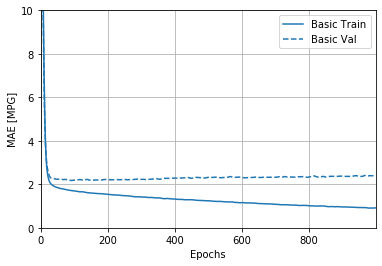

In [39]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')


Text(0, 0.5, 'MSE [MPG^2]')

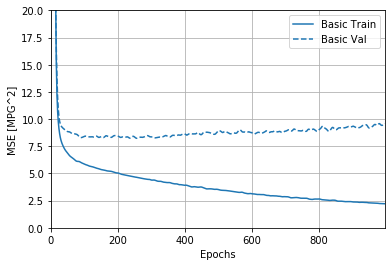

In [40]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')


In [41]:
# Let's update the model.fit call to automatically stop training when the validation score doesn't improve. 
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])



Epoch: 0, loss:578.7410,  mae:22.7524,  mse:578.7410,  val_loss:576.2480,  val_mae:22.6256,  val_mse:576.2480,  
..............................................

Text(0, 0.5, 'MAE [MPG]')

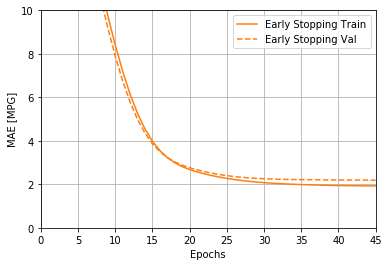

In [42]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')


In [43]:
#Let's see how well the model generalizes by using the test set, which we did not use when training the model.
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))


78/78 - 0s - loss: 6.2754 - mae: 1.9644 - mse: 6.2754
Testing set Mean Abs Error:  1.96 MPG


In [51]:
#Finally, predict MPG values using data in the testing set:
print(normed_test_data.shape) #Es 78 porque tenemos 78 casos. "rows" de datos
predictions = model.predict(normed_test_data)
print(predictions.shape) #78,1
test_predictions = predictions.flatten() # le quita el 1 del final
print(test_predictions.shape) # 78



(78, 9)
(78, 1)
(78,)


In [48]:
test_predictions #Esta es la predicción del MPG para cada caso, es decir para cada test_case que le pasamos.

array([15.791622, 11.742646, 13.210257, 23.511019, 20.48403 , 13.00992 ,
       13.366112, 12.421314, 19.09585 , 30.844076, 25.479662, 25.084982,
       14.285138, 26.400843, 12.926306, 13.823757, 14.790203, 13.187481,
       18.887362, 12.158001, 13.482872, 26.190554, 19.561192, 20.696383,
       30.772202, 23.906704, 15.61639 , 23.417887, 16.691477, 19.222366,
       28.564974, 20.475388, 18.706217, 21.93215 , 27.185598, 15.604429,
       19.458069, 32.329834, 30.832748, 17.092804, 31.511194, 29.710188,
       16.258814, 36.68215 , 35.404114, 36.11869 , 20.597864, 21.890293,
       20.810192, 27.125162, 31.122066, 19.203875, 32.91514 , 18.574375,
       17.673567, 18.026972, 34.448174, 35.7929  , 22.328604, 24.931906,
       38.737236, 34.00811 , 28.483374, 27.68445 , 32.74004 , 40.60671 ,
       37.89949 , 36.533394, 35.122173, 30.185026, 21.746061, 22.376314,
       30.416952, 31.594927, 37.406982, 37.075592, 39.432816, 31.095476],
      dtype=float32)

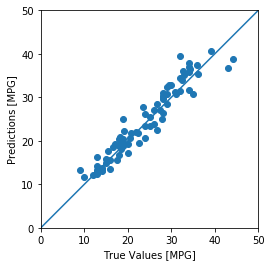

In [52]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


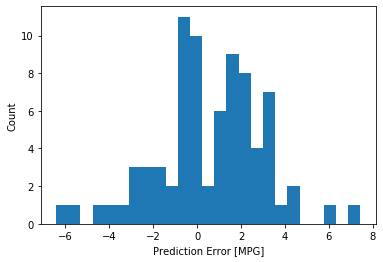

In [53]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
